<a href="https://colab.research.google.com/github/podo47/DL_HW1_Image_Classification_Pipeline/blob/main/DL__hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification Pipeline

## Mount to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive') #連接到自己的雲端

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Download data

In [ ]:
#@title
!pip install googleDriveFileDownloader #安裝套件語法 !pip install {套件名稱}

In [ ]:
#@title
from googleDriveFileDownloader import googleDriveFileDownloader
gdownloader = googleDriveFileDownloader()
gdownloader.downloadFile("https://drive.google.com/uc?id=1kwYYWL67O0Dcbx3dvZIfbGg9NiHdyisr&export=download") # 連結到home work 1 data並下載

In [ ]:
#@title
!unzip /content/images.zip -d /content/drive/MyDrive #解壓縮

# Part 1 : Data preprocessing

## Import libraries

In [ ]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for data visualization purposes
import seaborn as sns # for statistical data visualization
from skimage.feature import hog
from skimage.color import rgb2gray
from PIL import Image
import cv2

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Import data

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/images/train.txt', sep=" ",header=None)
train_dir = np.array(train[0])
train_y = np.array(train[1])

valid = pd.read_csv('/content/drive/MyDrive/images/val.txt', sep=" ",header=None)
valid_dir = np.array(valid[0])
valid_y = np.array(valid[1])

test = pd.read_csv('/content/drive/MyDrive/images/test.txt', sep=" ",header=None)
test_dir = np.array(test[0])
test_y = np.array(test[1])


## Read image into array (Can skip)

To save time, you can just skip these steps, as the output has already been stored

In [ ]:
def read_images_to_array(data_dir):
  X = []
  for imgname in data_dir:
      img = cv2.imread('/content/drive/MyDrive/'+imgname)
      img = cv2.resize(img, (32, 32))
      gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      X.append(gray)
  X = np.array(X)
  return X

In [ ]:
# To save time, you can just skip this step, as the output has already been stored

X_train = read_images_to_array(train_dir)
X_valid = read_images_to_array(valid_dir)
X_test = read_images_to_array(test_dir)


In [ ]:
# save them to a file
np.savez("/content/drive/MyDrive/images/dataset.npz", traindata=X_train, validdata=X_valid, testdata=X_test)

In [ ]:
# To save time, you can just skip this step, as the output has already been stored

with np.load("/content/drive/MyDrive/images/dataset.npz") as data:
    X_train = data["traindata"]
    X_valid = data["validdata"]
    X_test = data["testdata"]


## HOG (Can skip)

To save time, you can just skip these steps, as the output has already been stored

In [ ]:
# Define function to read images into an array
def HOG_features_train(X_train):
  orientations = 3
  pixels_per_cell = (4, 4)
  cells_per_block = (2, 2)
    
  train_features = []
  for image in X_train:
    feature = hog(image,orientations=orientations,pixels_per_cell=pixels_per_cell,cells_per_block=cells_per_block,block_norm='L2-Hys')
    train_features.append(feature)
  train_features = np.array(train_features)

  return train_features



In [ ]:
def HOG_features(X_valid,X_test):
  orientations = 3
  pixels_per_cell = (4, 4)
  cells_per_block = (2, 2)

  feature_data_list = []
  for i in [X_valid,X_test]:
    features_list = []
    for image in i:
      feature = hog(image,orientations=orientations,pixels_per_cell=pixels_per_cell,cells_per_block=cells_per_block,block_norm='L2-Hys')
      features_list.append(feature)
    features_list = np.array(features_list)
    feature_data_list.append(features_list)

  return feature_data_list

  

In [ ]:
norm_train_1 = HOG_features_train(X_train[0:20000])

In [ ]:
norm_train_2 = HOG_features_train(X_train[20000:40000])

In [ ]:
norm_train = np.append(norm_train_1,norm_train_2,0)

In [ ]:
# save them to a file
np.savez("/content/drive/MyDrive/images/norm_train.npz", norm_train_data=norm_train)

In [ ]:
norm_train_3 = HOG_features_train(X_train[40000:])

In [ ]:
# save them to a file
np.savez("/content/drive/MyDrive/images/norm_train_2.npz", norm_train_data=norm_train_3)

In [ ]:
with np.load("/content/drive/MyDrive/images/norm_train.npz") as data:
    norm_train = data["norm_train_data"]

In [ ]:
norm_train = np.append(norm_train,norm_train_3,0)

In [ ]:
# save them to a file
np.savez("/content/drive/MyDrive/images/norm_train_full.npz", norm_train_data=norm_train)

In [ ]:
with np.load("/content/drive/MyDrive/images/norm_train_full.npz") as data:
    hog_train = data["norm_train_data"]

In [ ]:
hog_feature = HOG_features(X_valid,X_test)

In [ ]:
hog_valid = hog_feature[0]
hog_test = hog_feature[1]

In [ ]:
# Calculate the mean and standard deviation of each feature over the training set
feature_means = np.mean(hog_train, axis=0)
feature_stds = np.std(hog_train, axis=0)

# Normalize the training set 
normalized_train_features = (hog_train - feature_means) / feature_stds

# Normalize the valid and test set using the same mean and standard deviation as the training set
normalized_valid_features = (hog_valid - feature_means) / feature_stds
normalized_test_features = (hog_test - feature_means) / feature_stds

In [ ]:
# save them to a file
np.savez("/content/drive/MyDrive/images/hog_data.npz", hog_train_data=normalized_train_features, hog_valid_data=normalized_valid_features,hog_test_data=normalized_test_features)

## Load feature vector and target variable

In [ ]:
with np.load("/content/drive/MyDrive/images/hog_data.npz") as data:
    hog_train = data["hog_train_data"]
    hog_valid = data["hog_valid_data"]
    hog_test = data["hog_test_data"]

# Part 2: Classifier

## XGBoost

In [ ]:
from xgboost import XGBClassifier
import joblib
from sklearn.metrics import accuracy_score

**Model training**

In [ ]:
xgb = XGBClassifier(n_estimators=10, learning_rate= 1.0,early_stopping_rounds=5)

**To save time, you can just skip these steps, as the output has already been stored in 'xgb_model.dat'**

In [ ]:
# Model training
# To save time, you can just skip these steps, as the output has already been stored in 'xgb_model.dat'
eval_set = [(hog_train, train_y), (hog_valid, valid_y)]
xgb.fit(hog_train, train_y, eval_set=eval_set, eval_metric='merror')

[0]	validation_0-merror:0.86598	validation_1-merror:0.98000
[1]	validation_0-merror:0.81001	validation_1-merror:0.98000
[2]	validation_0-merror:0.76396	validation_1-merror:0.96444
[3]	validation_0-merror:0.71683	validation_1-merror:0.97778
[4]	validation_0-merror:0.66181	validation_1-merror:0.97556
[5]	validation_0-merror:0.61000	validation_1-merror:0.98222
[6]	validation_0-merror:0.55975	validation_1-merror:0.97333
[7]	validation_0-merror:0.51133	validation_1-merror:0.97556


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=5,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1.0, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

**Store model**

In [ ]:
xgb_file = "/content/drive/MyDrive/images/xgb_model.dat"

# Store the model using joblib
'''
joblib.dump(xgb, xgb_file)
'''

'\njoblib.dump(xgb, xgb_file)\n'

In [ ]:
# Load the pretrained model
xgb_model = joblib.load(xgb_file)

**Check accuracy score**

The curves of the training accuracy and validation accuracy

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

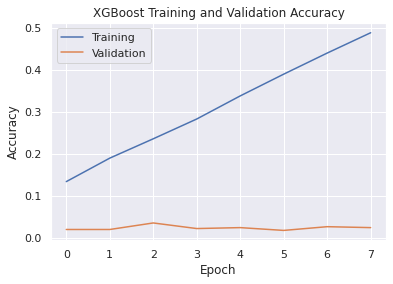

In [ ]:
# Get the training and validation accuracy scores
results_xgb = xgb_model.evals_result()
train_acc_xgb = [1-i for i in results_xgb['validation_0']['merror']]
val_acc_xgb = [1-i for i in results_xgb['validation_1']['merror']]

# Plot the training and validation accuracy curves
epochs_xgb = len(train_acc_xgb)
x_axis = range(0, epochs_xgb)
plt.plot(x_axis, train_acc_xgb, label='Training')
plt.plot(x_axis, val_acc_xgb, label='Validation')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('XGBoost Training and Validation Accuracy')
plt.show()

In [ ]:
# Valid set prediction
y_valid_xgb = xgb_model.predict(hog_valid)

**The predicted result on the validation/testing  set 
(evaluated in top-1 accuracy and top-5 accuracy)**

In [ ]:
# Calculate the top-1 accuracy of validation
top1_accuracy_xgb = accuracy_score(valid_y,y_valid_xgb)
print('Validation data Top-1 accuracy:{0:.2f}'.format(top1_accuracy_xgb))

# Get the top-5 predictions for the validation
y_valid_xgb_prob = xgb_model.predict_proba(hog_test)
y_val_pred_top5_xgb = np.argsort(y_valid_xgb_prob, axis=1)[:, -5:]
top5_accuracy_xgb_valid = np.mean(np.array([valid_y[i] in y_val_pred_top5_xgb[i] for i in range(len(valid_y))]))
print('Validation data Top-5 accuracy:{0:.2f}'.format(top5_accuracy_xgb_valid))

Validation data Top-1 accuracy:0.04
Validation data Top-5 accuracy:0.11


In [ ]:
# Evaluate the model on the testing set
# Test set prediction
y_test_xgb = xgb_model.predict(hog_test)
# Calculate the top-1 accuracy of train
top1_accuracy_xgb_test = accuracy_score(test_y,y_test_xgb)
print('Test data Top-1 accuracy:{0:.2f}'.format(top1_accuracy_xgb_test))

# Get the top-5 predictions for the train
y_test_xgb_prob = xgb_model.predict_proba(hog_test)
y_test_pred_top5_xgb = np.argsort(y_test_xgb_prob, axis=1)[:, -5:]
top5_accuracy_xgb_test = np.mean(np.array([test_y[i] in y_test_pred_top5_xgb[i] for i in range(len(test_y))]))
print('Test data Top-5 accuracy:{0:.2f}'.format(top5_accuracy_xgb_test))

Test data Top-1 accuracy:0.02
Test data Top-5 accuracy:0.11


## Catboost

In [ ]:
!pip install catboost
from catboost import CatBoostClassifier

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 10.0 MB/s eta 0:00:00


**Model training**

In [ ]:
cbc = CatBoostClassifier(learning_rate=0.1,eval_metric='Accuracy' ,early_stopping_rounds=15,verbose=True)  

**To save time, you can just skip these steps, as the output has already been stored in 'cbc_model.dat'**

In [ ]:
# Create a CatBoost classifier and fit it to the training data
# To save time, you can just skip these steps, as the output has already been stored in 'cbc_model.dat'
cbc.fit(hog_train, train_y, eval_set=(hog_valid, valid_y))

0:	learn: 0.0377892	test: 0.0222222	best: 0.0222222 (0)	total: 30.4s	remaining: 8h 26m 24s
1:	learn: 0.0459218	test: 0.0200000	best: 0.0222222 (0)	total: 1m	remaining: 8h 25m 19s
2:	learn: 0.0557126	test: 0.0200000	best: 0.0222222 (0)	total: 1m 31s	remaining: 8h 24m 25s
3:	learn: 0.0627398	test: 0.0200000	best: 0.0222222 (0)	total: 2m 1s	remaining: 8h 24m 24s
4:	learn: 0.0669720	test: 0.0200000	best: 0.0222222 (0)	total: 2m 32s	remaining: 8h 24m 24s
5:	learn: 0.0706198	test: 0.0200000	best: 0.0222222 (0)	total: 3m 2s	remaining: 8h 25m 12s
6:	learn: 0.0761153	test: 0.0200000	best: 0.0222222 (0)	total: 3m 34s	remaining: 8h 26m 12s
7:	learn: 0.0785314	test: 0.0200000	best: 0.0222222 (0)	total: 4m 5s	remaining: 8h 27m 12s
8:	learn: 0.0834741	test: 0.0200000	best: 0.0222222 (0)	total: 4m 37s	remaining: 8h 29m 19s
9:	learn: 0.0847375	test: 0.0200000	best: 0.0222222 (0)	total: 5m 10s	remaining: 8h 33m 2s
10:	learn: 0.0907540	test: 0.0200000	best: 0.0222222 (0)	total: 5m 42s	remaining: 8h 32m 

**Store model**

In [ ]:
cbc_file = "/content/drive/MyDrive/images/cbc_model.dat"

# Store the model using joblib
'''
joblib.dump(cbc, cbc_file)
'''

'\njoblib.dump(cbc, cbc_file)\n'

In [ ]:
# Load the pretrained model
cbc_model = joblib.load(cbc_file)

In [ ]:
train_metrics_cbc = cbc.evals_result_['learn']['Accuracy']
val_metrics_cbc = cbc.evals_result_['validation']['Accuracy']

path_cbc = '/content/drive/MyDrive/images/eval_results_cbc.pkl'

'''
with open(path_cbc, 'wb') as f:
    joblib.dump({'train': train_metrics_cbc, 'validation': val_metrics_cbc}, f)

'''

In [ ]:
with open(path_cbc, 'rb') as f:
    eval_results_cbc = joblib.load(f)

**Check accuracy score**

The curves of the training accuracy and validation accuracy

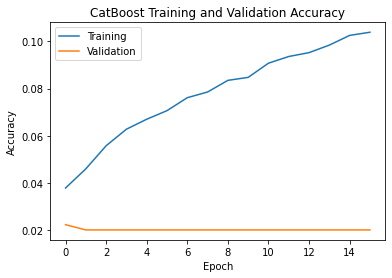

In [ ]:
# Get the training and validation accuracy scores
results_cbc = cbc_model.get_evals_result()
train_acc_cbc = eval_results_cbc['train']
val_acc_cbc = eval_results_cbc['validation']

# Plot the training and validation accuracy curves
epochs_cbc = len(train_acc_cbc)
x_axis = range(0, epochs_cbc)
plt.plot(x_axis, train_acc_cbc, label='Training')
plt.plot(x_axis, val_acc_cbc, label='Validation')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('CatBoost Training and Validation Accuracy')
plt.show()

In [ ]:
# Valid set prediction
y_valid_cbc = cbc_model.predict(hog_valid)

**The predicted result on the validation/testing set (evaluated in top-1 accuracy and top-5 accuracy)**

In [ ]:
# Calculate the top-1 accuracy of validation
top1_accuracy_cbc = accuracy_score(valid_y,y_valid_cbc)
print('Validation data Top-1 accuracy:{0:.2f}'.format(top1_accuracy_cbc))

# Get the top-5 predictions for the validation
y_valid_cbc_prob = cbc_model.predict_proba(hog_test)
y_val_pred_top5_cbc = np.argsort(y_valid_cbc_prob, axis=1)[:, -5:]
top5_accuracy_cbc_valid = np.mean(np.array([valid_y[i] in y_val_pred_top5_cbc[i] for i in range(len(valid_y))]))
print('Validation data Top-5 accuracy:{0:.2f}'.format(top5_accuracy_cbc_valid))

Validation data Top-1 accuracy:0.02
Validation data Top-5 accuracy:0.10


In [ ]:
# Evaluate the model on the testing set
# Test set prediction
y_test_cbc = cbc_model.predict(hog_test)
# Calculate the top-1 accuracy of train
top1_accuracy_cbc_test = accuracy_score(test_y,y_test_cbc)
print('Test data Top-1 accuracy:{0:.2f}'.format(top1_accuracy_cbc_test))

# Get the top-5 predictions for the train
y_test_cbc_prob = cbc_model.predict_proba(hog_test)
y_test_pred_top5_cbc = np.argsort(y_test_cbc_prob, axis=1)[:, -5:]
top5_accuracy_cbc_test = np.mean(np.array([test_y[i] in y_test_pred_top5_cbc[i] for i in range(len(test_y))]))
print('Test data Top-5 accuracy:{0:.2f}'.format(top5_accuracy_cbc_test))

Test data Top-1 accuracy:0.02
Test data Top-5 accuracy:0.10


## Light GBM

In [ ]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

**Model training**

In [ ]:
lgbm = lgb.LGBMClassifier(n_estimators = 10,learning_rate = 1.0)

**To save time, you can just skip these steps, as the output has already been stored in 'lgbm_model.dat'**

In [ ]:
# To save time, you can just skip these steps, as the output has already been stored in 'lgbm_model.dat'
eval_set = [(hog_train, train_y), (hog_valid, valid_y)]
lgbm.fit(hog_train, train_y, eval_set=eval_set, eval_metric='multi_error', early_stopping_rounds=15, verbose=True)

[1]	training's multi_error: 0.870809	training's multi_logloss: 4.98671	valid_1's multi_error: 0.98	valid_1's multi_logloss: 5.26715
[2]	training's multi_error: 0.841611	training's multi_logloss: 6.06854	valid_1's multi_error: 0.977778	valid_1's multi_logloss: 4.79977
[3]	training's multi_error: 0.830651	training's multi_logloss: 6.90481	valid_1's multi_error: 0.968889	valid_1's multi_logloss: 4.88907
[4]	training's multi_error: 0.824272	training's multi_logloss: 7.45148	valid_1's multi_error: 0.971111	valid_1's multi_logloss: 4.91966
[5]	training's multi_error: 0.823593	training's multi_logloss: 8.02334	valid_1's multi_error: 0.968889	valid_1's multi_logloss: 4.96019
[6]	training's multi_error: 0.825156	training's multi_logloss: 8.50045	valid_1's multi_error: 0.968889	valid_1's multi_logloss: 4.94324
[7]	training's multi_error: 0.829009	training's multi_logloss: 8.98034	valid_1's multi_error: 0.968889	valid_1's multi_logloss: 4.95109
[8]	training's multi_error: 0.83542	training's multi

LGBMClassifier(learning_rate=1.0, n_estimators=10)

**Store model**

In [ ]:
lgbm_file = "/content/drive/MyDrive/images/lgbm_model.dat"

# Store the model using joblib
'''
joblib.dump(lgbm, lgbm_file)
'''

'\njoblib.dump(lgbm, lgbm_file)\n'

In [ ]:
# Load the pretrained model
lgbm_model = joblib.load(lgbm_file)

In [ ]:
print(lgbm_model.evals_result_.keys())


dict_keys(['training', 'valid_1'])


**Check accuracy score**

The curves of the training accuracy and validation accuracy

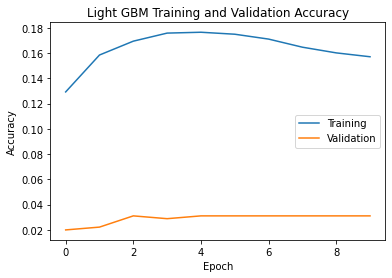

In [ ]:
# Get the training and validation accuracy scores
train_acc_lgbm = lgbm_model.evals_result_['training']['multi_error']
val_acc_lgbm = lgbm_model.evals_result_['valid_1']['multi_error']
train_acc_lgbm = [1-i for i in train_acc_lgbm ]
val_acc_lgbm = [1-i for i in val_acc_lgbm ]
# Plot the training and validation accuracy curves
epochs_lgbm = len(train_acc_lgbm)
x_axis = range(0, epochs_lgbm)
plt.plot(x_axis, train_acc_lgbm, label='Training')
plt.plot(x_axis, val_acc_lgbm, label='Validation')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Light GBM Training and Validation Accuracy')
plt.show()

In [ ]:
# Valid set prediction
y_valid_lgbm = lgbm_model.predict(hog_valid)

**The predicted result on the validation/testing set (evaluated in top-1 accuracy and top-5 accuracy)**

In [ ]:
# Calculate the top-1 accuracy of validation
top1_accuracy_lgbm = accuracy_score(valid_y,y_valid_lgbm)
print('Validation data Top-1 accuracy:{0:.2f}'.format(top1_accuracy_lgbm))

# Get the top-5 predictions for the validation
y_valid_lgbm_prob = lgbm_model.predict_proba(hog_test)
y_val_pred_top5_lgbm = np.argsort(y_valid_lgbm_prob, axis=1)[:, -5:]
top5_accuracy_lgbm_valid = np.mean(np.array([valid_y[i] in y_val_pred_top5_lgbm[i] for i in range(len(valid_y))]))
print('Validation data Top-5 accuracy:{0:.2f}'.format(top5_accuracy_lgbm_valid))

Validation data Top-1 accuracy:0.03
Validation data Top-5 accuracy:0.11


In [ ]:
# Evaluate the model on the testing set
# Test set prediction
y_test_lgbm = lgbm_model.predict(hog_test)
# Calculate the top-1 accuracy of train
top1_accuracy_lgbm_test = accuracy_score(test_y,y_test_lgbm)
print('Test data Top-1 accuracy:{0:.2f}'.format(top1_accuracy_lgbm_test))

# Get the top-5 predictions for the train
y_test_lgbm_prob = lgbm_model.predict_proba(hog_test)
y_test_pred_top5_lgbm = np.argsort(y_test_lgbm_prob, axis=1)[:, -5:]
top5_accuracy_lgbm_test = np.mean(np.array([test_y[i] in y_test_pred_top5_lgbm[i] for i in range(len(test_y))]))
print('Test data Top-5 accuracy:{0:.2f}'.format(top5_accuracy_lgbm_test))

Test data Top-1 accuracy:0.03
Test data Top-5 accuracy:0.11


# Performance

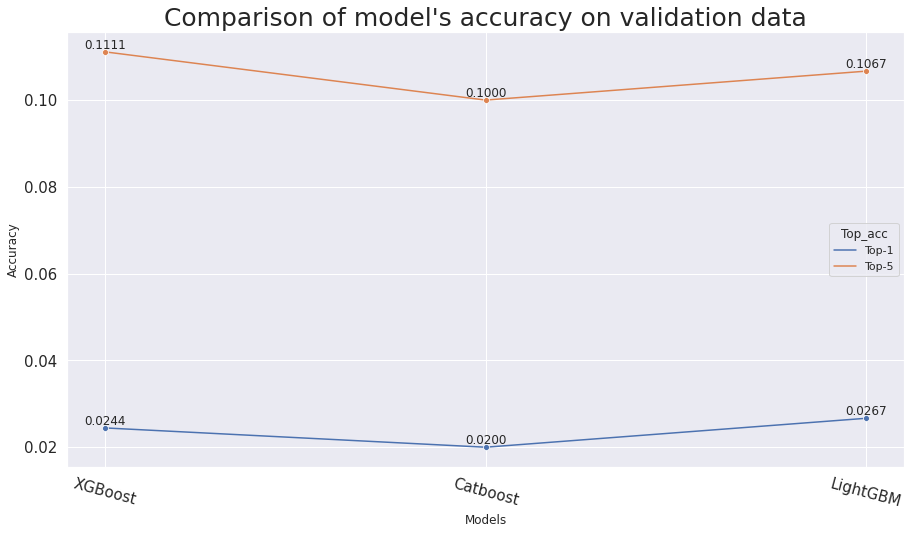

In [ ]:
perform_df = pd.DataFrame([
    ['XGBoost', 'Top-1', top1_accuracy_xgb_test],
    ['XGBoost', 'Top-5', top5_accuracy_xgb_test],
    ['Catboost', 'Top-1', top1_accuracy_cbc_test],
    ['Catboost', 'Top-5', top5_accuracy_cbc_test],
    ['LightGBM', 'Top-1', top1_accuracy_lgbm_test],
    ['LightGBM', 'Top-5', top5_accuracy_lgbm_test]], columns=['Models', 'Top_acc', 'Accuracy'])

plt.xticks(rotation=-15,size=15)
plt.yticks(size=15)
sns.set(rc = {'figure.figsize':(15,8)})
model_perform_plot = sns.lineplot(x='Models', y='Accuracy', hue='Top_acc',marker='o', data=perform_df)
model_perform_plot.set_title("Comparison of model's accuracy on validation data",size=25)

for a,b in zip(perform_df['Models'],perform_df['Accuracy']):
  plt.text(a, b, '%.4f' % b, ha='center', va= 'bottom',fontsize=12)

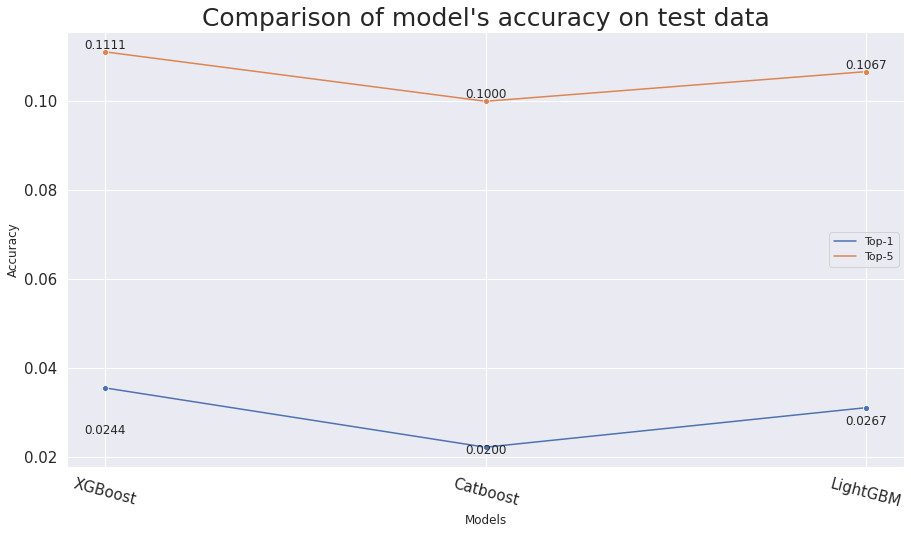

In [ ]:
perform_df_test = pd.DataFrame([
    ['XGBoost', 'Top-1', top1_accuracy_xgb],
    ['XGBoost', 'Top-5', top5_accuracy_xgb_valid],
    ['Catboost', 'Top-1', top1_accuracy_cbc],
    ['Catboost', 'Top-5', top5_accuracy_cbc_valid],
    ['LightGBM', 'Top-1', top1_accuracy_lgbm],
    ['LightGBM', 'Top-5', top5_accuracy_lgbm_valid]], columns=['Models', 'Top_acc', 'Accuracy'])

plt.xticks(rotation=-15,size=15)
plt.yticks(size=15)
sns.set(rc = {'figure.figsize':(15,8)})
model_perform_plot = sns.lineplot(x='Models', y='Accuracy', hue='Top_acc',marker='o', data=perform_df_test)
model_perform_plot.set_title("Comparison of model's accuracy on test data",size=25)
plt.legend(loc='center right')

for a,b in zip(perform_df['Models'],perform_df['Accuracy']):
  plt.text(a, b, '%.4f' % b, ha='center', va= 'bottom',fontsize=12)